In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import torch

from tensorflow import keras
from tensorflow.keras import layers

In [2]:
cin = 3
rank = [3, 3]
kernel_size = [3, 3]
filters = cout = 3
classes = 10


In [3]:
def get_dataset(take_first=None):
    (train_images, train_labels), (test_images, test_labels) = keras.datasets.cifar10.load_data() 

    train_images = train_images / 255.0
    test_images = test_images / 255.0

    if take_first is not None:
        train_images = train_images[:take_first, ...]
        train_labels = train_labels[:take_first]
    train_images = train_images

    return train_images, train_labels, test_images, test_labels

In [4]:
train_images, train_labels, test_images, test_labels = get_dataset()

In [5]:
input_shape = train_images.shape[1:]

In [6]:
tf_model = tf.keras.Sequential(
    [
        tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, padding='valid', activation='relu',
                               input_shape=input_shape),
        tf.keras.layers.Conv2D(filters=50, kernel_size=(3, 3), padding='valid', activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(classes, activation='softmax')
    ]
)


In [7]:
tf_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

tf_model.fit(train_images,
          train_labels,
          epochs=1)
tf_model.summary()

Train on 50000 samples
50000/50000 [==============================] - 71s 1ms/sample - loss: 1.4449 - accuracy: 0.4914
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 3)         84        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 50)        1400      
_________________________________________________________________
flatten (Flatten)            (None, 39200)             0         
_________________________________________________________________
dense (Dense)                (None, 10)                392010    
Total params: 393,494
Trainable params: 393,494
Non-trainable params: 0
_________________________________________________________________


In [8]:
import torch.nn as nn

conv_weight, conv_bias = tf_model.layers[0].get_weights()
dense_weight, dense_bias = tf_model.layers[-1].get_weights()

print('Evaluate source model')
test_loss, test_acc = tf_model.evaluate(test_images,
                                     test_labels,
                                     verbose=0)
print('Test accuracy:', test_acc)

Evaluate source model
Test accuracy: 0.5782


In [9]:
def to_tf_kernel_order(tensor):
    """Change conv.kernel axis order from PyTorch to Tensoflow.

    :param tensor: tensor with conv.kernel weights.
    :return: tensor with the Tensoflow-like exis order.
    []
    """
    return np.transpose(tensor, (2, 3, 1, 0))


def to_pytorch_kernel_order(tensor):
    """Change conv.kernel axis order from Tensoflow to PyTorch.

    :param tensor: tensor with conv.kernel weights.
    :return: tensor with the Pytorch-like exis order.
    []
    """
    return np.transpose(tensor, (3, 2, 0, 1))

In [10]:
torch_model_original = nn.Sequential(
                            nn.Conv2d(in_channels=cin,
                                      out_channels=filters,
                                      kernel_size=kernel_size),
                            nn.ReLU(),
                            nn.Flatten(),
                            nn.Linear(39200, classes),
                           )

torch_test = torch.from_numpy(np.transpose(test_images, (0, 3, 1, 2)).astype(np.float32)).float()

# _ = torch_model_original(torch_test)

print(torch_model_original[0].weight.data.numpy().shape)
print(torch_model_original[-1].weight.data.numpy().shape)
torch_model_original[0].weight.data = torch.from_numpy(to_pytorch_kernel_order(conv_weight.astype(np.float32))).float()
torch_model_original[0].bias.data = torch.from_numpy(conv_bias.astype(np.float32)).float()
torch_model_original[-1].weight.data = torch.from_numpy(dense_weight.astype(np.float32)).T.float()
torch_model_original[-1].bias.data = torch.from_numpy(dense_bias.astype(np.float32)).float()


(3, 3, 3, 3)
(10, 39200)


In [11]:
to_pytorch_kernel_order(conv_weight).shape, dense_weight.shape

((3, 3, 3, 3), (39200, 10))

In [12]:
torch_answer = np.transpose(torch_model_original[0](torch_test).data.numpy(), (0, 2, 3, 1))
torch_answer = torch_model_original[1](torch.from_numpy(torch_answer).float()).data.numpy()
tf_answer = tf_model.layers[0](test_images.astype(np.float32))

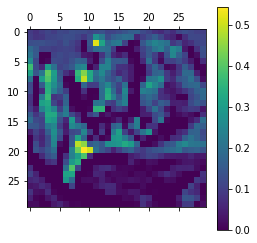

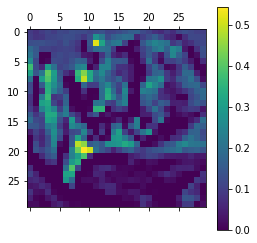

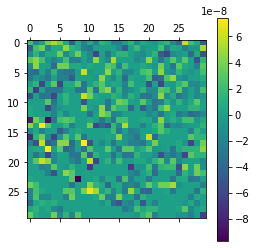

In [13]:
plt.matshow(torch_answer[0, ..., 0])
plt.colorbar()
plt.show()

plt.matshow(tf_answer[0, ..., 0])
plt.colorbar()
plt.show()


plt.matshow(tf_answer[0, ..., 0] - torch_answer[0, ..., 0])
plt.colorbar()
plt.show()

In [14]:
from tqdm import tqdm
norms = []
for idx in tqdm(range(torch_answer.shape[0])):
    norms.append(np.linalg.norm(torch_answer[idx, ...] - tf_answer[idx, ...]))

100%|██████████| 10000/10000 [00:02<00:00, 3453.89it/s]


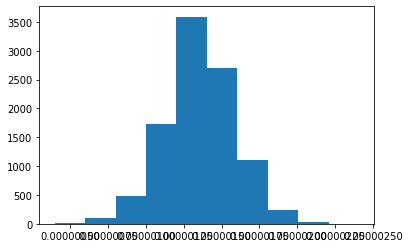

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt


plt.hist(norms)
plt.show()

In [16]:
rank

[3, 3]

In [17]:
from sktensor import dtensor, tucker


pytorch_weight  = to_pytorch_kernel_order(conv_weight)
pytorch_weight = pytorch_weight.reshape((*pytorch_weight.shape[:2], -1))

core, (U_cout, U_cin, U_dd) = tucker.hooi(dtensor(pytorch_weight),
                                            [rank[0],
                                             rank[1],
                                             pytorch_weight.shape[-1]], init='nvecs')
core = core.dot(U_dd.T)

w_cin = np.array(U_cin)
w_core = np.array(core)
w_cout = np.array(U_cout)

w_cin = np.reshape(w_cin.T, [rank[1], cin, 1, 1])
w_core = np.reshape(w_core, [rank[0], rank[1], *kernel_size])
w_cout = np.reshape(w_cout, [cout, rank[0], 1, 1])

/anaconda2/envs/tf-2-n/lib/python3.7/site-packages/sktensor/tucker.py:113: RuntimeWarning: invalid value encountered in sqrt
  normresidual = np.sqrt(normX ** 2 - norm(core) ** 2)


In [18]:
torch_model = nn.Sequential(
                            nn.Conv2d(in_channels=cin,
                                      out_channels=rank[1],
                                      kernel_size=(1, 1),
                                      bias=False),
                            nn.Conv2d(in_channels=rank[1],
                                      out_channels=rank[0],
                                      kernel_size=kernel_size,
                                      bias=False),
                            nn.Conv2d(in_channels=rank[0],
                                      out_channels=cout,
                                      kernel_size=(1, 1)),
                            nn.ReLU(),
                            nn.Flatten(),
                            nn.Linear(39200, classes),
                           )

In [19]:
torch_model[0].weight.data = torch.from_numpy(w_cin).float()
torch_model[1].weight.data = torch.from_numpy(w_core).float()
torch_model[2].weight.data = torch.from_numpy(w_cout).float()
torch_model[2].bias.data = torch.from_numpy(conv_bias).float()
torch_model[-1].weight.data = torch.from_numpy(dense_weight.T).float()
torch_model[-1].bias.data = torch.from_numpy(dense_bias).float()

In [20]:
original_answer = torch_model_original[0](torch_test).data.numpy()

x = torch_test
for idx in range(3):
    x = torch_model[idx](x)
x = x.data.numpy()

In [21]:
x

array([[[[ 9.55597535e-02,  7.75422752e-02,  9.70978588e-02, ...,
           1.15480199e-01,  1.03676781e-01,  9.78944376e-02],
         [ 1.01742126e-01,  8.16808119e-02,  8.72753486e-02, ...,
           1.18090652e-01,  1.15569957e-01,  1.10028423e-01],
         [ 1.30175695e-01,  1.33136615e-01,  1.35543227e-01, ...,
           7.44858980e-02,  1.09875515e-01,  1.14890344e-01],
         ...,
         [ 8.27720687e-02,  2.49706004e-02,  2.01124381e-02, ...,
           7.97593147e-02,  6.23693280e-02, -4.04498167e-02],
         [ 5.13380989e-02,  8.21702182e-03, -1.05754733e-02, ...,
           1.38901860e-01,  1.03520878e-01,  6.94601331e-03],
         [ 1.50137339e-02,  1.72747131e-02, -1.10093167e-03, ...,
           9.42592621e-02, -1.07597392e-02,  2.07469258e-02]],

        [[ 7.14781359e-02,  6.78543821e-02,  4.59812731e-02, ...,
           4.28043492e-02,  2.85563171e-02,  2.32939869e-02],
         [ 7.49026090e-02,  7.35468939e-02,  4.43972386e-02, ...,
           6.26742914e

In [22]:
original_answer

array([[[[ 9.55598131e-02,  7.75422677e-02,  9.70979333e-02, ...,
           1.15480222e-01,  1.03676908e-01,  9.78944898e-02],
         [ 1.01742215e-01,  8.16808417e-02,  8.72753933e-02, ...,
           1.18090764e-01,  1.15569994e-01,  1.10028461e-01],
         [ 1.30175725e-01,  1.33136645e-01,  1.35543332e-01, ...,
           7.44859055e-02,  1.09875560e-01,  1.14890441e-01],
         ...,
         [ 8.27721730e-02,  2.49706618e-02,  2.01124828e-02, ...,
           7.97593296e-02,  6.23693056e-02, -4.04497720e-02],
         [ 5.13381697e-02,  8.21708143e-03, -1.05754323e-02, ...,
           1.38901904e-01,  1.03520945e-01,  6.94598164e-03],
         [ 1.50137851e-02,  1.72747970e-02, -1.10092119e-03, ...,
           9.42592844e-02, -1.07597280e-02,  2.07469594e-02]],

        [[ 7.14781359e-02,  6.78543299e-02,  4.59812395e-02, ...,
           4.28043343e-02,  2.85563599e-02,  2.32939478e-02],
         [ 7.49025345e-02,  7.35469237e-02,  4.43972424e-02, ...,
           6.26743510e

In [23]:
np.linalg.norm(x - original_answer)

0.0005215441

In [24]:
x.shape

(10000, 3, 30, 30)

In [25]:
original_answer.shape

(10000, 3, 30, 30)

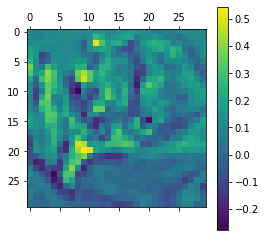

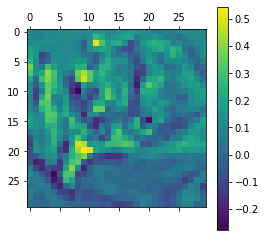

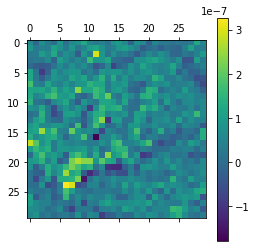

In [26]:
plt.matshow(original_answer[0, 0, :, :])
plt.colorbar()
plt.show()

plt.matshow(x[0, 0, :, :])
plt.colorbar()
plt.show()

plt.matshow(original_answer[0, 0, :, :] - x[0, 0, :, :])
plt.colorbar()
plt.show()

In [27]:
w_cin.shape

(3, 3, 1, 1)

In [28]:
np.linalg.norm(original_answer[0, 0, :, :] - x[0, 0, :, :])

2.4488745e-06